In [82]:
from pathlib import Path
import json
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.ops import unary_union

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100

DATA = Path('..') / 'data'
OUTPUTS = DATA / 'outputs'
PROCESSED = DATA / 'processed'
RAW = DATA / 'raw'
PROJECTED_CRS = 32720

## 1. Load Validated Data

In [83]:
# Load boundary metadata
with open(OUTPUTS / 'boundary_metadata.json') as f:
    meta = json.load(f)

# Load all processed layers
landuse = gpd.read_file(PROCESSED / 'landuse.gpkg')
pois = gpd.read_file(PROCESSED / 'pois.gpkg')
buildings = gpd.read_file(PROCESSED / 'buildings.gpkg')
poi_grid = gpd.read_file(PROCESSED / 'poi_grid.gpkg')
building_grid = gpd.read_file(PROCESSED / 'building_grid.gpkg')
street_edges = gpd.read_file(PROCESSED / 'street_edges.gpkg')

# Load neighborhoods from KML with proper name parsing
neighborhoods_path = RAW / 'neighborhoods.kml'
if neighborhoods_path.exists():
    import xml.etree.ElementTree as ET
    import re
    
    # Load geometries with GeoPandas
    neighborhoods = gpd.read_file(neighborhoods_path, driver='KML')
    neighborhoods = neighborhoods.to_crs(PROJECTED_CRS)
    
    # Parse KML XML to extract neighborhood names from Description
    tree = ET.parse(neighborhoods_path)
    root = tree.getroot()
    ns = {'kml': 'http://www.opengis.net/kml/2.2'}
    
    names = []
    for placemark in root.findall('.//kml:Placemark', ns):
        desc = placemark.find('kml:description', ns)
        if desc is not None and desc.text:
            # Extract "Nombre" from HTML table
            match = re.search(r'<td>Nombre</td>\s*<td>([^<]+)</td>', desc.text, re.IGNORECASE)
            if match:
                names.append(match.group(1).strip())
            else:
                names.append(None)
        else:
            names.append(None)
    
    # Add parsed names to GeoDataFrame
    if len(names) == len(neighborhoods):
        neighborhoods['Name'] = names
        # Fallback to index for any that failed
        neighborhoods.loc[neighborhoods['Name'].isna(), 'Name'] = 'Unknown_' + neighborhoods.index.astype(str)
        print(f'✓ Loaded {len(neighborhoods)} neighborhoods with {sum([n is not None for n in names])} names parsed')
    else:
        print(f'⚠ Warning: Mismatch between geometries ({len(neighborhoods)}) and names ({len(names)})')
        neighborhoods['Name'] = 'Unknown_' + neighborhoods.index.astype(str)
else:
    neighborhoods = gpd.GeoDataFrame()
    print(f'⚠ KML file not found at {neighborhoods_path}')

print('✓ All datasets loaded')
print(f'City area: {meta["area_km2"]:.2f} km²')
print(f'Neighborhoods: {len(neighborhoods)}')
print(f'POIs: {len(pois)}')
print(f'Buildings: {len(buildings)}')
print(f'Grid cells: {len(poi_grid)}')

✓ Loaded 485 neighborhoods with 485 names parsed
✓ All datasets loaded
City area: 575.55 km²
Neighborhoods: 485
POIs: 1530
Buildings: 16239
Grid cells: 2400


## 2. Land Use Distribution Analysis

**Question 1**: How is land use distributed within the city boundary?

In [84]:
# Calculate land use areas and percentages
landuse['area_km2'] = landuse.geometry.area / 1e6

landuse_summary = landuse.groupby('category').agg({
    'area_km2': 'sum'
}).reset_index()

landuse_summary['percentage'] = (landuse_summary['area_km2'] / meta['area_km2']) * 100
landuse_summary = landuse_summary.sort_values('area_km2', ascending=False)

print('=== Land Use Distribution ===')
print(landuse_summary.to_string(index=False))
print(f'\nTotal mapped land use: {landuse_summary["area_km2"].sum():.2f} km² ({landuse_summary["percentage"].sum():.1f}% of city)')

=== Land Use Distribution ===
                 category   area_km2  percentage
      landuse:residential 193.885024   33.686886
         landuse:military  33.152303    5.760104
         landuse:farmland  30.720517    5.337589
       landuse:industrial  25.148737    4.369510
            natural:heath  23.723359    4.121856
             leisure:park   8.428727    1.464464
            landuse:grass   6.181563    1.074026
            natural:scrub   2.787460    0.484312
             natural:wood   1.917151    0.333099
            natural:water   1.532450    0.266258
     landuse:construction   0.910917    0.158269
           landuse:retail   0.877596    0.152479
          natural:wetland   0.850522    0.147775
         landuse:landfill   0.747406    0.129859
       landuse:commercial   0.734154    0.127557
          landuse:railway   0.562730    0.097772
        natural:grassland   0.473273    0.082230
         landuse:cemetery   0.403607    0.070125
landuse:recreation_ground   0.114518   

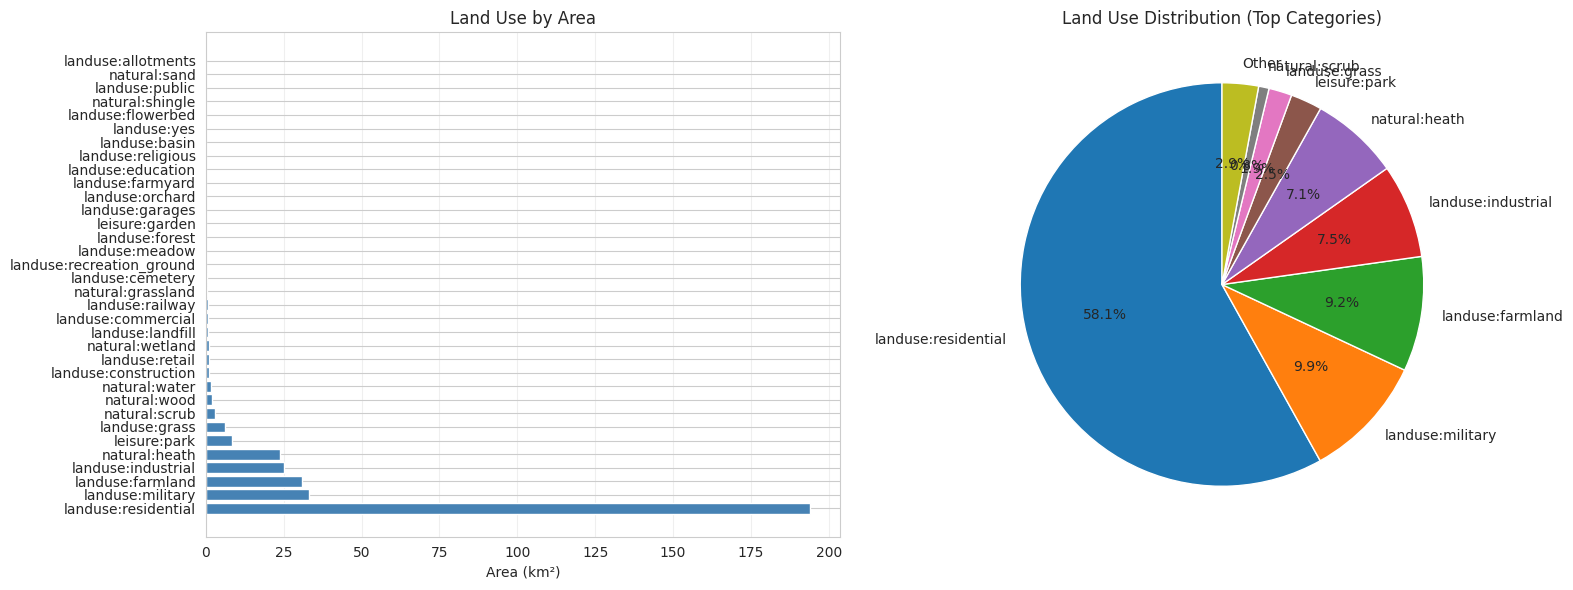

In [85]:
# Visualize land use distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart
ax1.barh(landuse_summary['category'], landuse_summary['area_km2'], color='steelblue')
ax1.set_xlabel('Area (km²)')
ax1.set_title('Land Use by Area')
ax1.grid(axis='x', alpha=0.3)

# Pie chart (top categories)
top_landuse = landuse_summary.head(8)
other_area = landuse_summary.iloc[8:]['area_km2'].sum() if len(landuse_summary) > 8 else 0

if other_area > 0:
    plot_data = pd.concat([
        top_landuse,
        pd.DataFrame({'category': ['Other'], 'area_km2': [other_area]})
    ])
else:
    plot_data = top_landuse

ax2.pie(plot_data['area_km2'], labels=plot_data['category'], autopct='%1.1f%%', startangle=90)
ax2.set_title('Land Use Distribution (Top Categories)')

plt.tight_layout()
plt.show()

## 3. Neighborhood-Level Aggregation

Aggregate all indicators by neighborhood for spatial comparison.

In [86]:
# Calculate neighborhood areas
neighborhoods['area_km2'] = neighborhoods.geometry.area / 1e6

print(f'Analyzing {len(neighborhoods)} neighborhoods')
print(f'Neighborhood area range: {neighborhoods["area_km2"].min():.3f} - {neighborhoods["area_km2"].max():.2f} km²')
print(f'Mean neighborhood area: {neighborhoods["area_km2"].mean():.3f} km²')

Analyzing 485 neighborhoods
Neighborhood area range: 0.016 - 22.93 km²
Mean neighborhood area: 0.855 km²


In [87]:
# Spatial join POIs to neighborhoods
pois_nh = gpd.sjoin(pois, neighborhoods[['Name', 'geometry']], how='inner', predicate='within')

# Count POIs per neighborhood
poi_counts = pois_nh.groupby('Name').size().reset_index(name='poi_count')

# Merge with neighborhoods
nh_analysis = neighborhoods[['Name', 'area_km2', 'geometry']].merge(poi_counts, on='Name', how='left')
nh_analysis['poi_count'] = nh_analysis['poi_count'].fillna(0).astype(int)
nh_analysis['poi_density'] = nh_analysis['poi_count'] / nh_analysis['area_km2']

print(f'\nPOIs matched to neighborhoods: {len(pois_nh)} / {len(pois)} ({len(pois_nh)/len(pois)*100:.1f}%)')


POIs matched to neighborhoods: 1515 / 1530 (99.0%)


In [88]:
# Spatial join buildings to neighborhoods
buildings_centroids = buildings.copy()
buildings_centroids['geometry'] = buildings.geometry.centroid

buildings_nh = gpd.sjoin(buildings_centroids, neighborhoods[['Name', 'geometry']], how='inner', predicate='within')

# Count and aggregate building area per neighborhood
buildings_nh['building_area_km2'] = buildings.loc[buildings_nh.index, 'geometry'].area / 1e6

building_stats = buildings_nh.groupby('Name').agg({
    'building_area_km2': 'sum',
    'Name': 'size'  # count
}).rename(columns={'Name': 'building_count'}).reset_index()

# Merge with neighborhoods
nh_analysis = nh_analysis.merge(building_stats, on='Name', how='left')
nh_analysis['building_count'] = nh_analysis['building_count'].fillna(0).astype(int)
nh_analysis['building_area_km2'] = nh_analysis['building_area_km2'].fillna(0)
nh_analysis['building_density'] = nh_analysis['building_count'] / nh_analysis['area_km2']
nh_analysis['footprint_coverage'] = (nh_analysis['building_area_km2'] / nh_analysis['area_km2']) * 100

print(f'Buildings matched to neighborhoods: {len(buildings_nh)} / {len(buildings)} ({len(buildings_nh)/len(buildings)*100:.1f}%)')

Buildings matched to neighborhoods: 15706 / 16239 (96.7%)


In [89]:
# Display summary statistics
print('\n=== Neighborhood Statistics Summary ===')
print(nh_analysis[['poi_count', 'poi_density', 'building_count', 'building_density', 'footprint_coverage']].describe())


=== Neighborhood Statistics Summary ===
        poi_count  poi_density  building_count  building_density  \
count  485.000000   485.000000      485.000000        485.000000   
mean     3.395876     7.148868       33.383505         62.564622   
std     14.695954    26.008822       95.873978        173.779558   
min      0.000000     0.000000        0.000000          0.000000   
25%      0.000000     0.000000        0.000000          0.000000   
50%      1.000000     1.884918        2.000000          7.007603   
75%      2.000000     5.618375       16.000000         27.237171   
max    241.000000   363.802825      944.000000       1511.204076   

       footprint_coverage  
count          485.000000  
mean             5.394485  
std             28.562215  
min              0.000000  
25%              0.000000  
50%              0.461762  
75%              2.001068  
max            415.073610  


## 4. Neighborhood Rankings

Identify top and bottom neighborhoods by key indicators.

In [90]:
# Top 10 neighborhoods by POI density
print('=== Top 10 Neighborhoods by POI Density ===')
top_poi = nh_analysis.nlargest(10, 'poi_density')[['Name', 'area_km2', 'poi_count', 'poi_density']]
print(top_poi.to_string(index=False))

print('\n=== Bottom 10 Neighborhoods by POI Density ===')
bottom_poi = nh_analysis.nsmallest(10, 'poi_density')[['Name', 'area_km2', 'poi_count', 'poi_density']]
print(bottom_poi.to_string(index=False))

=== Top 10 Neighborhoods by POI Density ===
         Name  area_km2  poi_count  poi_density
           SD  0.016492          6   363.802825
           SD  0.018812          6   318.941820
           SD  0.043041          6   139.400587
NUEVA CORDOBA  1.223631        154   125.854958
           SD  0.051744          6   115.956529
           SD  0.061090          6    98.215062
           SD  0.062643          6    95.780387
           SD  0.064262          6    93.368496
       CENTRO  3.124022        241    77.144139
           SD  0.085636          6    70.063885

=== Bottom 10 Neighborhoods by POI Density ===
               Name  area_km2  poi_count  poi_density
  VILLA GRAN PARQUE  3.907729          0          0.0
            LOURDES  0.155226          0          0.0
        GUIÑAZU SUD  0.039373          0          0.0
           SAN JOSE  0.138987          0          0.0
QUINTAS DE ARGUELLO  0.077522          0          0.0
       ALBORADA (N)  0.060291          0          0.0
  

In [91]:
# Top 10 neighborhoods by building density
print('=== Top 10 Neighborhoods by Building Density ===')
top_bld = nh_analysis.nlargest(10, 'building_density')[['Name', 'area_km2', 'building_count', 'building_density']]
print(top_bld.to_string(index=False))

print('\n=== Bottom 10 Neighborhoods by Building Density ===')
bottom_bld = nh_analysis.nsmallest(10, 'building_density')[['Name', 'area_km2', 'building_count', 'building_density']]
print(bottom_bld.to_string(index=False))

=== Top 10 Neighborhoods by Building Density ===
              Name  area_km2  building_count  building_density
           MAURIZI  0.111831             169       1511.204076
 VILLA REVOL ANEXO  0.189179             256       1353.212172
                SD  0.016492              21       1273.309888
                SD  0.018812              21       1116.296369
       EL TROPEZON  0.124346             110        884.628678
  BAJADA SAN ROQUE  0.052737              46        872.251640
           A.T. E.  0.177987             141        792.190890
        CRISOL SUD  0.516535             403        780.198652
  CAROLA LORENZINI  0.073561              55        747.677481
PARQUE MONTECRISTO  0.217843             154        706.932081

=== Bottom 10 Neighborhoods by Building Density ===
               Name  area_km2  building_count  building_density
  VILLA GRAN PARQUE  3.907729               0               0.0
            LOURDES  0.155226               0               0.0
        GUIÑA

## 5. Spatial Patterns - Center vs Periphery

Analyze how indicators vary by distance from city center.

In [92]:
# Calculate distance from city center (centroid)
import osmnx as ox
boundary = ox.geocode_to_gdf('R5167559', by_osmid=True).to_crs(PROJECTED_CRS)
city_center = boundary.geometry.centroid.iloc[0]

nh_analysis['dist_from_center'] = nh_analysis.geometry.centroid.distance(city_center) / 1000  # km

print(f'Distance from center range: {nh_analysis["dist_from_center"].min():.2f} - {nh_analysis["dist_from_center"].max():.2f} km')

Distance from center range: 0.25 - 15.93 km


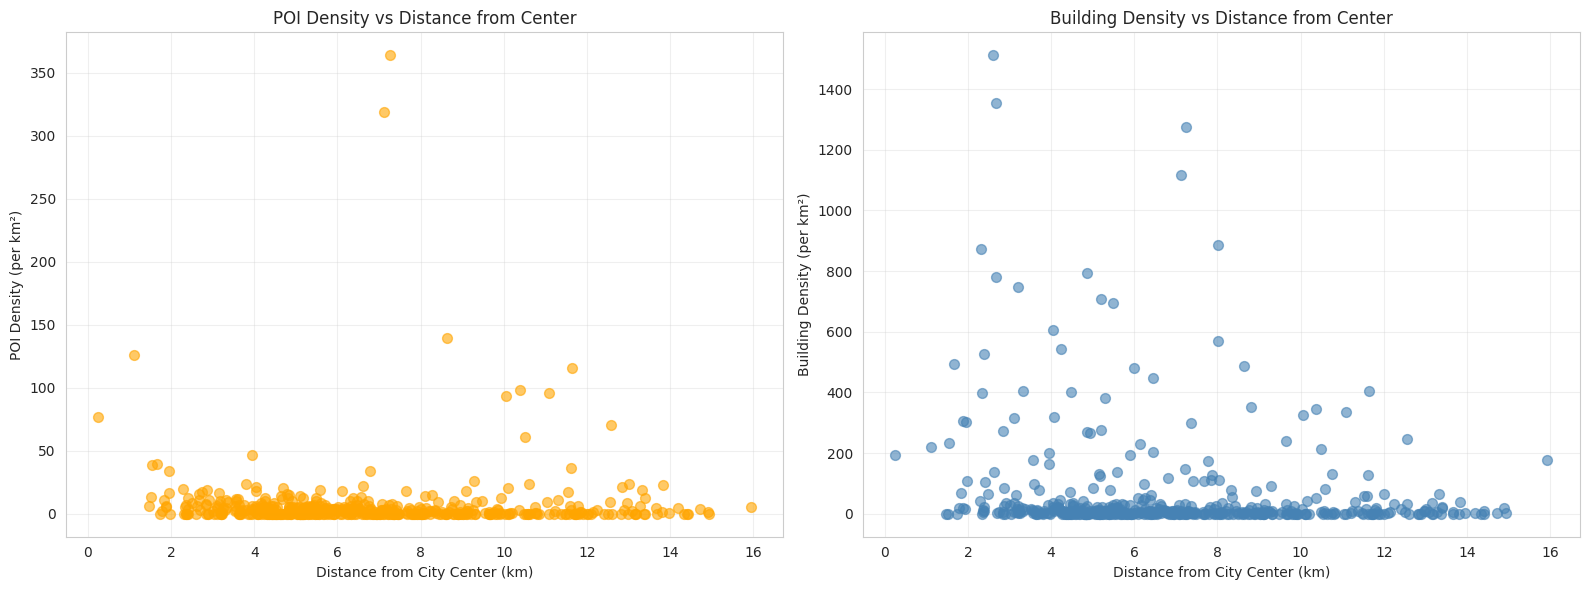


Correlation: Distance from center vs POI density: 0.003
Correlation: Distance from center vs Building density: -0.153


In [93]:
# Scatter plots: density vs distance from center
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# POI density vs distance
ax1.scatter(nh_analysis['dist_from_center'], nh_analysis['poi_density'], alpha=0.6, s=50, color='orange')
ax1.set_xlabel('Distance from City Center (km)')
ax1.set_ylabel('POI Density (per km²)')
ax1.set_title('POI Density vs Distance from Center')
ax1.grid(True, alpha=0.3)

# Building density vs distance
ax2.scatter(nh_analysis['dist_from_center'], nh_analysis['building_density'], alpha=0.6, s=50, color='steelblue')
ax2.set_xlabel('Distance from City Center (km)')
ax2.set_ylabel('Building Density (per km²)')
ax2.set_title('Building Density vs Distance from Center')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate correlation
corr_poi = nh_analysis[['dist_from_center', 'poi_density']].corr().iloc[0, 1]
corr_bld = nh_analysis[['dist_from_center', 'building_density']].corr().iloc[0, 1]

print(f'\nCorrelation: Distance from center vs POI density: {corr_poi:.3f}')
print(f'Correlation: Distance from center vs Building density: {corr_bld:.3f}')

## 6. Underserved Areas Analysis

**Question 3**: Which areas show spatial imbalance or potential under-service?

In [ ]:
# Define thresholds for "underserved" (below 25th percentile)
poi_threshold = nh_analysis['poi_density'].quantile(0.50)
building_threshold = nh_analysis['building_density'].quantile(0.30)

# Identify underserved neighborhoods
nh_analysis['underserved_poi'] = nh_analysis['poi_density'] < poi_threshold
nh_analysis['underserved_building'] = nh_analysis['building_density'] < building_threshold
nh_analysis['underserved_both'] = nh_analysis['underserved_poi'] & nh_analysis['underserved_building']

print(f'POI density threshold (50th percentile): {poi_threshold:.2f} POIs/km²')
print(f'Building density threshold (30th percentile): {building_threshold:.2f} buildings/km²')
print(f'\nUnderserved neighborhoods:')
print(f'  Low POI density: {nh_analysis["underserved_poi"].sum()}')
print(f'  Low building density: {nh_analysis["underserved_building"].sum()}')
print(f'  Both indicators low: {nh_analysis["underserved_both"].sum()}')

POI density threshold (75th percentile): 1.88 POIs/km²
Building density threshold (50th percentile): 0.60 buildings/km²

Underserved neighborhoods:
  Low POI density: 242
  Low building density: 146
  Both indicators low: 92


In [111]:
# List underserved neighborhoods (both indicators)
print('\n=== Neighborhoods with Low POI and Building Density ===')
underserved = nh_analysis[nh_analysis['underserved_both']][[
    'Name', 'area_km2', 'poi_count', 'poi_density', 'building_count', 'building_density', 'dist_from_center'
]].sort_values('area_km2', ascending=False)

print(underserved.to_string(index=False))
print(f'\nTotal area underserved: {underserved["area_km2"].sum():.2f} km² ({underserved["area_km2"].sum()/meta["area_km2"]*100:.1f}% of city)')


=== Neighborhoods with Low POI and Building Density ===
                       Name  area_km2  poi_count  poi_density  building_count  building_density  dist_from_center
        CAMINO A 60 CUADRAS 16.899561          0     0.000000               1          0.059173         10.801471
          ESTACION FERREYRA 15.919983          0     0.000000               1          0.062814         11.742512
               LA CARBONADA  8.720889          1     0.114667               1          0.114667         14.420203
          VILLA GRAN PARQUE  3.907729          0     0.000000               0          0.000000         10.109182
               VILLA RETIRO  3.030764          1     0.329950               1          0.329950         10.201374
             MARIA LASTENIA  2.297784          1     0.435202               0          0.000000          9.906674
                LA FLORESTA  2.044628          3     1.467260               1          0.489087         11.859557
              EL QUEBRACHAL  1.

## 7. Infrastructure Diversity Analysis

Analyze POI category distribution across neighborhoods.

In [96]:
# POI diversity per neighborhood
poi_diversity = pois_nh.groupby(['Name', 'category']).size().reset_index(name='count')
poi_categories_per_nh = poi_diversity.groupby('Name')['category'].nunique().reset_index(name='category_count')

nh_analysis = nh_analysis.merge(poi_categories_per_nh, on='Name', how='left')
nh_analysis['category_count'] = nh_analysis['category_count'].fillna(0).astype(int)

print('=== POI Category Diversity ===')
print(f'Max categories in a neighborhood: {nh_analysis["category_count"].max()}')
print(f'Mean categories per neighborhood: {nh_analysis["category_count"].mean():.1f}')
print(f'Neighborhoods with 0 POIs: {(nh_analysis["category_count"] == 0).sum()}')

=== POI Category Diversity ===
Max categories in a neighborhood: 16
Mean categories per neighborhood: 1.6
Neighborhoods with 0 POIs: 200


In [97]:
# Show POI category breakdown
print('\n=== POI Categories Overview ===')
print(f'Total unique POI categories in city: {pois["category"].nunique()}')
print(f'\nCategory distribution:')
print(pois['category'].value_counts())

print('\n=== Category Combinations in Neighborhoods ===')
# For neighborhoods with POIs, show what categories they have
nh_with_pois = nh_analysis[nh_analysis['category_count'] > 0].sort_values('category_count', ascending=False)

print(f'\nTop 15 neighborhoods by diversity:')
for idx, row in nh_with_pois.head(15).iterrows():
    nh_name = row['Name']
    # Get categories in this neighborhood
    categories = poi_diversity[poi_diversity['Name'] == nh_name]['category'].tolist()
    print(f"\n{nh_name} ({row['category_count']} categories, {row['poi_count']} POIs):")
    for cat in categories:
        count = poi_diversity[(poi_diversity['Name'] == nh_name) & (poi_diversity['category'] == cat)]['count'].values[0]
        print(f"  - {cat}: {count}")


=== POI Categories Overview ===
Total unique POI categories in city: 20

Category distribution:
category
unknown                     365
amenity:restaurant          161
amenity:pharmacy            160
amenity:school              145
amenity:clinic              106
amenity:cafe                 98
amenity:fuel                 96
amenity:bank                 88
amenity:parking              83
amenity:place_of_worship     61
leisure:playground           48
amenity:police               25
amenity:hospital             22
amenity:dentist              21
leisure:sports_centre        17
amenity:library              13
amenity:post_office          10
amenity:fire_station          5
leisure:park                  5
amenity:ice_cream             1
Name: count, dtype: int64

=== Category Combinations in Neighborhoods ===

Top 15 neighborhoods by diversity:

CENTRO (16 categories, 241 POIs):
  - amenity:bank: 29
  - amenity:cafe: 26
  - amenity:clinic: 8
  - amenity:dentist: 3
  - amenity:fuel: 1
  

In [98]:
# Top neighborhoods by POI diversity
print('\n=== Top 10 Neighborhoods by POI Diversity ===')
top_diversity = nh_analysis.nlargest(10, 'category_count')[['Name', 'poi_count', 'category_count']]
print(top_diversity.to_string(index=False))


=== Top 10 Neighborhoods by POI Diversity ===
              Name  poi_count  category_count
            CENTRO        241              16
           ALBERDI         83              13
      ALTA CORDOBA         88              13
       GENERAL PAZ         45              12
            GUEMES         46              12
        SAN MARTIN         16              11
     NUEVA CORDOBA        154              11
    LOS BOULEVARES         20              10
      ALTO ALBERDI         47               9
GENERAL PUEYRREDON         17               9


## 8. Correlation Analysis

Explore relationships between indicators.

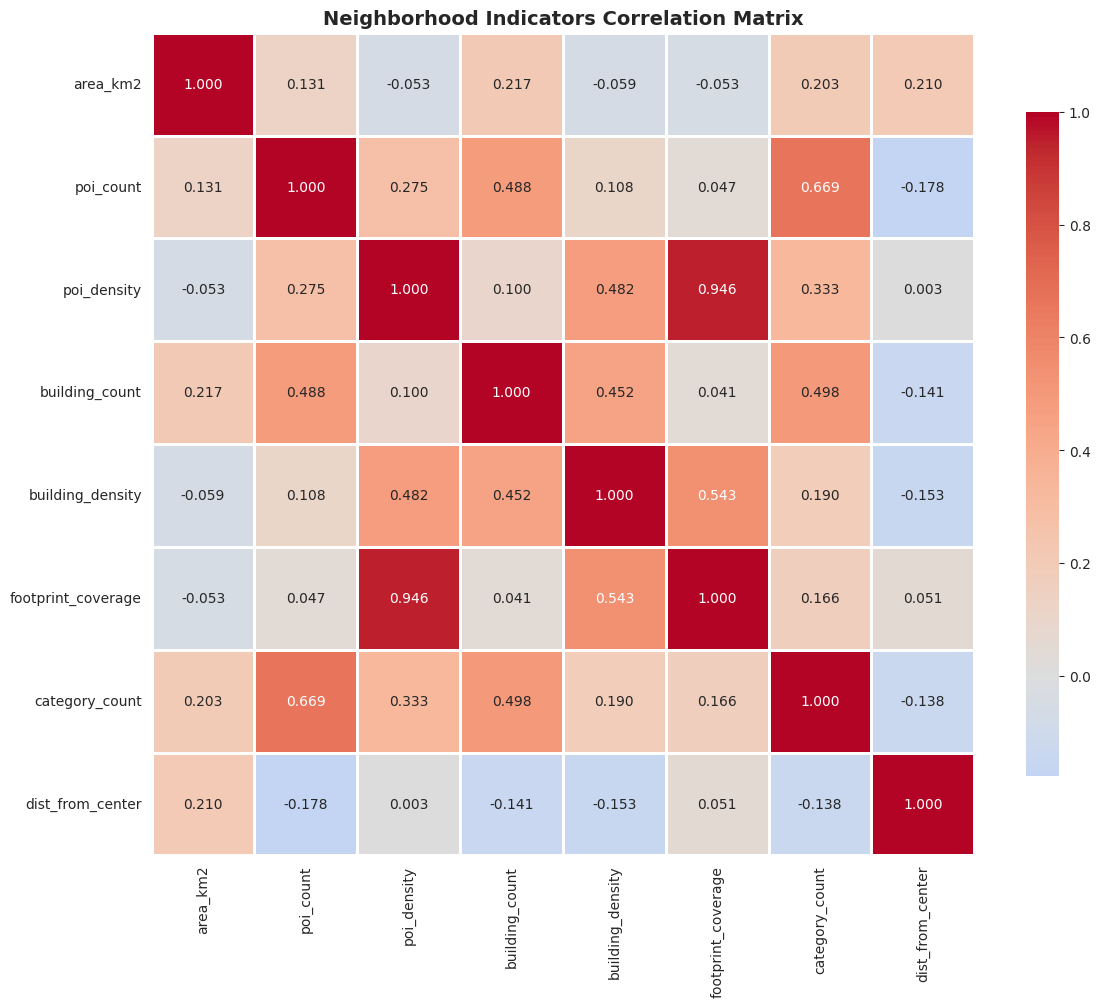


=== Key Correlations ===
POI density vs Building density: 0.482
POI density vs Distance from center: 0.003
Building density vs Distance from center: -0.153
POI diversity vs POI density: 0.333


In [99]:
# Correlation matrix
corr_cols = ['area_km2', 'poi_count', 'poi_density', 'building_count', 'building_density', 
             'footprint_coverage', 'category_count', 'dist_from_center']

corr = nh_analysis[corr_cols].corr()

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt='.3f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax)
ax.set_title('Neighborhood Indicators Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print('\n=== Key Correlations ===')
print(f'POI density vs Building density: {corr.loc["poi_density", "building_density"]:.3f}')
print(f'POI density vs Distance from center: {corr.loc["poi_density", "dist_from_center"]:.3f}')
print(f'Building density vs Distance from center: {corr.loc["building_density", "dist_from_center"]:.3f}')
print(f'POI diversity vs POI density: {corr.loc["category_count", "poi_density"]:.3f}')

## 9. Spatial Visualization - Choropleth Maps

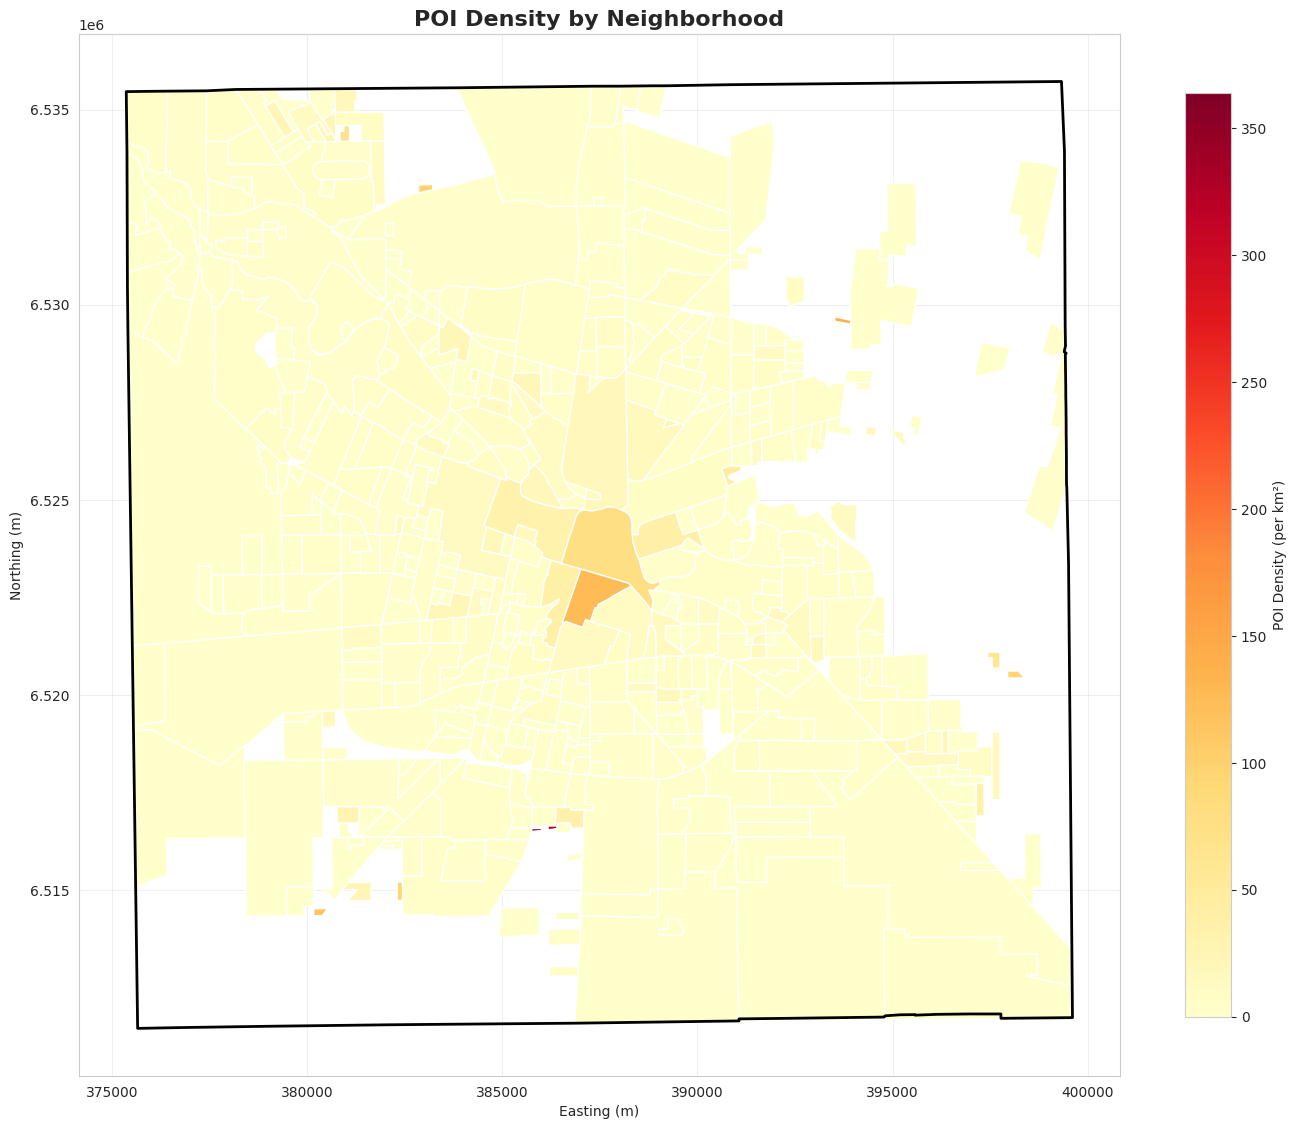

In [100]:
# Map 1: POI Density
fig, ax = plt.subplots(figsize=(14, 12))

nh_analysis.plot(column='poi_density', cmap='YlOrRd', legend=True, ax=ax,
                 legend_kwds={'label': 'POI Density (per km²)', 'shrink': 0.8})
boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=2)

ax.set_title('POI Density by Neighborhood', fontsize=16, fontweight='bold')
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

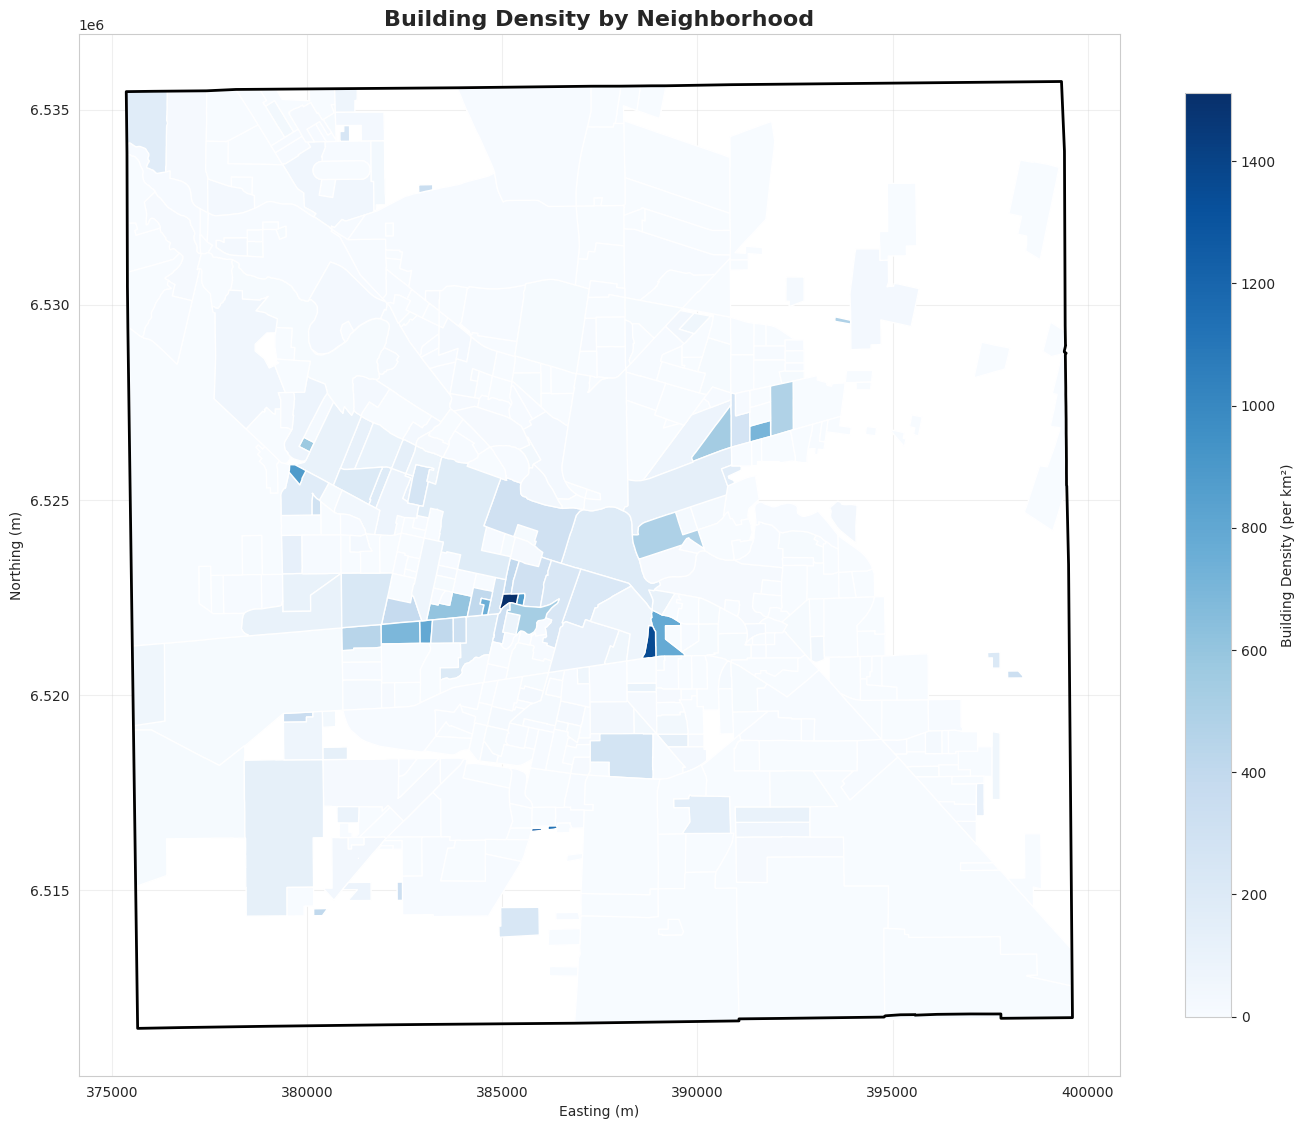

In [101]:
# Map 2: Building Density
fig, ax = plt.subplots(figsize=(14, 12))

nh_analysis.plot(column='building_density', cmap='Blues', legend=True, ax=ax,
                 legend_kwds={'label': 'Building Density (per km²)', 'shrink': 0.8})
boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=2)

ax.set_title('Building Density by Neighborhood', fontsize=16, fontweight='bold')
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

/tmp/ipykernel_38057/1052911528.py:17: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='best')
/tmp/ipykernel_38057/1052911528.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='best')


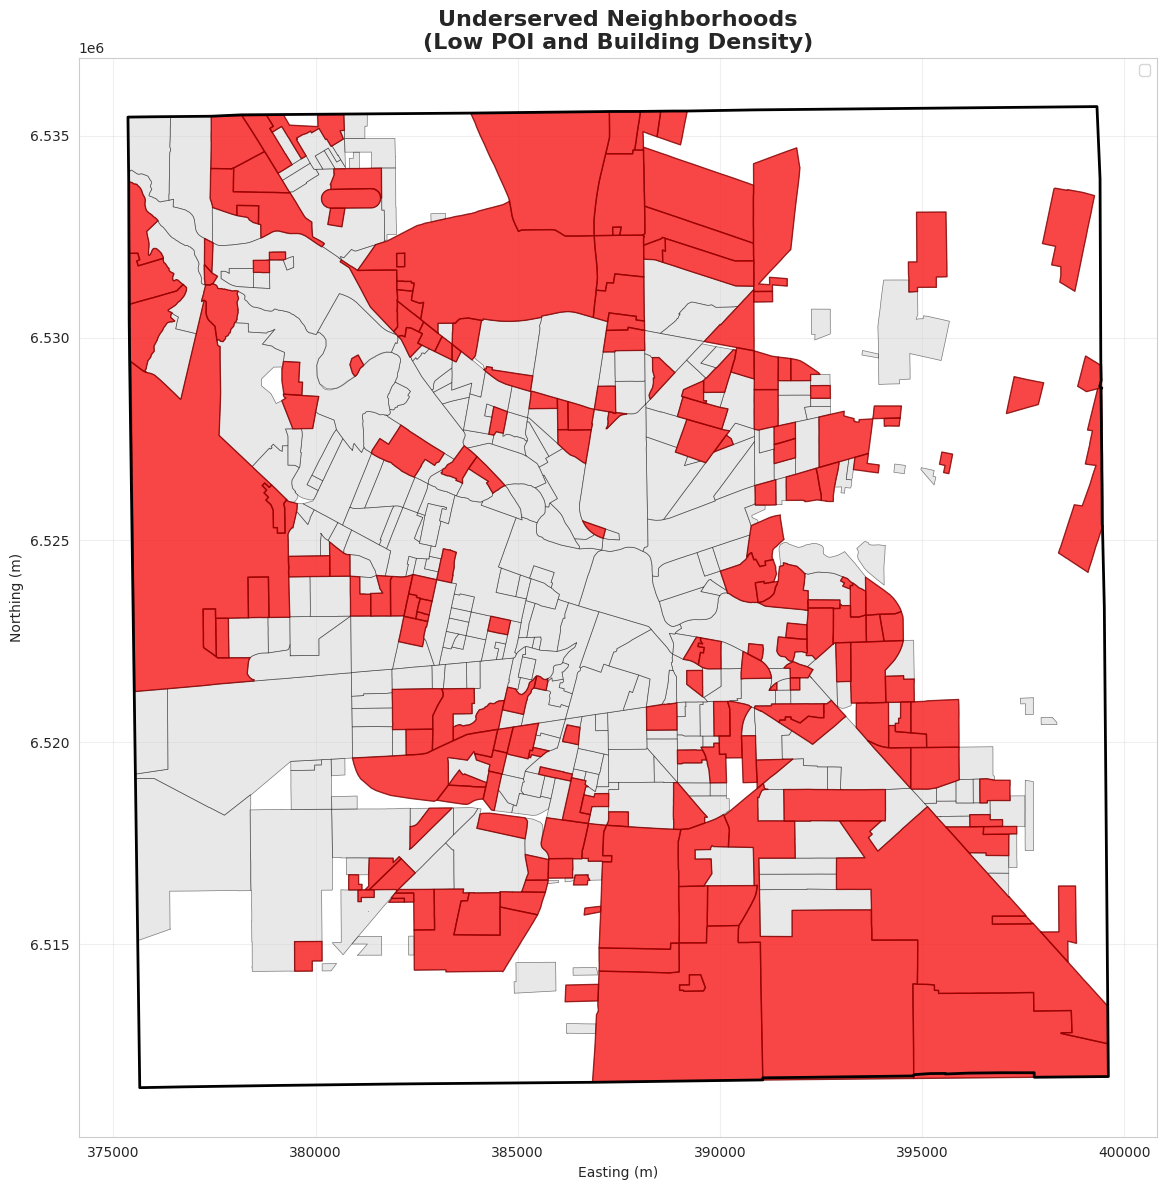

In [102]:
# Map 3: Underserved Areas
fig, ax = plt.subplots(figsize=(14, 12))

# Plot all neighborhoods
nh_analysis.plot(ax=ax, color='lightgray', edgecolor='black', linewidth=0.5, alpha=0.5, label='Other neighborhoods')

# Highlight underserved
underserved_geom = nh_analysis[nh_analysis['underserved_both']]
if not underserved_geom.empty:
    underserved_geom.plot(ax=ax, color='red', edgecolor='darkred', linewidth=1, alpha=0.7, label='Underserved (both)')

boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=2, label='City boundary')

ax.set_title('Underserved Neighborhoods\n(Low POI and Building Density)', fontsize=16, fontweight='bold')
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 10. Key Findings Summary

In [103]:
print('='*70)
print('KEY FINDINGS'.center(70))
print('='*70)

print('\n### 1. LAND USE DISTRIBUTION')
print(f'   - Total mapped land use: {landuse_summary["area_km2"].sum():.2f} km² ({landuse_summary["percentage"].sum():.1f}% of city)')
print(f'   - Dominant category: {landuse_summary.iloc[0]["category"]} ({landuse_summary.iloc[0]["percentage"]:.1f}%)')

print('\n### 2. NEIGHBORHOOD VARIATION')
print(f'   - POI density range: {nh_analysis["poi_density"].min():.2f} - {nh_analysis["poi_density"].max():.2f} per km²')
print(f'   - Building density range: {nh_analysis["building_density"].min():.2f} - {nh_analysis["building_density"].max():.2f} per km²')
print(f'   - Highest POI density: {nh_analysis.nlargest(1, "poi_density")["Name"].values[0]}')
print(f'   - Highest building density: {nh_analysis.nlargest(1, "building_density")["Name"].values[0]}')

print('\n### 3. SPATIAL PATTERNS')
print(f'   - Center-periphery correlation (POI): {corr_poi:.3f}')
print(f'   - Center-periphery correlation (Building): {corr_bld:.3f}')
if corr_poi < -0.3:
    print('   → Strong central concentration of POIs')
if corr_bld < -0.3:
    print('   → Strong central concentration of buildings')

print('\n### 4. UNDERSERVED AREAS')
print(f'   - Neighborhoods with low infrastructure: {nh_analysis["underserved_both"].sum()}')
print(f'   - Total underserved area: {underserved["area_km2"].sum():.2f} km²')
print(f'   - Percentage of city: {underserved["area_km2"].sum()/meta["area_km2"]*100:.1f}%')

print('\n### 5. INFRASTRUCTURE DIVERSITY')
print(f'   - Average POI categories per neighborhood: {nh_analysis["category_count"].mean():.1f}')
print(f'   - Neighborhoods with no POIs: {(nh_analysis["poi_count"] == 0).sum()}')

print('\n### 6. DATA QUALITY')
print(f'   - POIs matched to neighborhoods: {len(pois_nh)/len(pois)*100:.1f}%')
print(f'   - Buildings matched to neighborhoods: {len(buildings_nh)/len(buildings)*100:.1f}%')
print(f'   - Neighborhood coverage of city: {nh_analysis["area_km2"].sum()/meta["area_km2"]*100:.1f}%')

print('\n' + '='*70)

                             KEY FINDINGS                             

### 1. LAND USE DISTRIBUTION
   - Total mapped land use: 333.75 km² (58.0% of city)
   - Dominant category: landuse:residential (33.7%)

### 2. NEIGHBORHOOD VARIATION
   - POI density range: 0.00 - 363.80 per km²
   - Building density range: 0.00 - 1511.20 per km²
   - Highest POI density: SD
   - Highest building density: MAURIZI

### 3. SPATIAL PATTERNS
   - Center-periphery correlation (POI): 0.003
   - Center-periphery correlation (Building): -0.153

### 4. UNDERSERVED AREAS
   - Neighborhoods with low infrastructure: 202
   - Total underserved area: 207.92 km²
   - Percentage of city: 36.1%

### 5. INFRASTRUCTURE DIVERSITY
   - Average POI categories per neighborhood: 1.6
   - Neighborhoods with no POIs: 200

### 6. DATA QUALITY
   - POIs matched to neighborhoods: 99.0%
   - Buildings matched to neighborhoods: 96.7%
   - Neighborhood coverage of city: 72.0%



## 11. Export Results

In [104]:
# Save neighborhood analysis
nh_analysis.to_file(OUTPUTS / 'neighborhood_analysis.gpkg', driver='GPKG')
print(f'✓ Neighborhood analysis saved to {OUTPUTS / "neighborhood_analysis.gpkg"}')

# Save CSV summary
nh_summary = nh_analysis.drop(columns='geometry')[[
    'Name', 'area_km2', 'poi_count', 'poi_density', 'building_count', 'building_density',
    'footprint_coverage', 'category_count', 'dist_from_center', 
    'underserved_poi', 'underserved_building', 'underserved_both'
]]
nh_summary.to_csv(OUTPUTS / 'neighborhood_summary.csv', index=False)
print(f'✓ Neighborhood summary saved to {OUTPUTS / "neighborhood_summary.csv"}')

# Save land use summary
landuse_summary.to_csv(OUTPUTS / 'landuse_summary.csv', index=False)
print(f'✓ Land use summary saved to {OUTPUTS / "landuse_summary.csv"}')

✓ Neighborhood analysis saved to ../data/outputs/neighborhood_analysis.gpkg
✓ Neighborhood summary saved to ../data/outputs/neighborhood_summary.csv
✓ Land use summary saved to ../data/outputs/landuse_summary.csv


---

## Analysis Complete

This notebook answered the core research questions:

1. ✅ **Land use distribution** analyzed and visualized
2. ✅ **Infrastructure variation** quantified across neighborhoods
3. ✅ **Underserved areas** identified using density thresholds
4. ✅ **Spatial patterns** revealed (center vs periphery)
